## TASK:  
Text classification (50+ classes).  
Metric - accuracy.

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from tqdm import tqdm
from google.colab import drive
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model
from keras.layers import (Input, Embedding, Dropout, Dense, concatenate,
                          SpatialDropout1D, Convolution1D, GlobalMaxPool1D)

%matplotlib inline
%load_ext autoreload
%autoreload 2

nltk.download("stopwords")
drive.mount('/content/drive')
sns.set_style('whitegrid', rc={'grid.linestyle': '--'});
pd.options.display.max_columns=100
pd.options.display.max_rows=100
pd.options.display.max_colwidth = -1
pd.options.mode.chained_assignment = None 
tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load data

In [0]:
# Data directory
dir_path = "drive/My Drive/avito/"

In [0]:
# Function to display key information about dataset
def preview_data(data):
    print("data shape: {}".format(data.shape))
    print("size, MB: {:.2f}".format(data.memory_usage(deep=True).sum() / 1e6))
    display(pd.concat([data.isnull().sum().rename("NaN"),
                       data.dtypes.rename("dtype")], axis=1))
    display(data.head(2))

In [14]:
# Category data
category = pd.read_csv(dir_path + "category.csv", index_col="category_id")
preview_data(category)

data shape: (54, 1)
size, MB: 0.01


,NaN,dtype
name,0,object


,name
category_id,
0,Бытовая электроника|Телефоны|iPhone
1,Бытовая электроника|Ноутбуки


In [0]:
# Train data
train = pd.read_csv(dir_path + "train.csv", index_col="item_id")
preview_data(train)

data shape: (489517, 4)
size, MB: 384.51


,NaN,dtype
title,0,object
description,0,object
price,0,float64
category_id,0,int64


,title,description,price,category_id
item_id,,,,
0,Картина,Гобелен. Размеры 139х84см.,1000.0,19
1,Стулья из прессованной кожи,"Продам недорого 4 стула из светлой прессованной кожи, стильные, ножки дугообразные.",1250.0,22


In [0]:
# Test data
test = pd.read_csv(dir_path + "test.csv", index_col="item_id")
preview_data(test)

data shape: (243166, 3)
size, MB: 188.52


,NaN,dtype
title,0,object
description,0,object
price,0,float64


,title,description,price
item_id,,,
489517,Стоик журнальный сталь,продам журнальный столик изготавливаю столы из полированной нержавеющей стали и стекла или камня на всю продукцию даю гарантию стоимость зависит от размеров и дизайна,10000.0
489518,iPhone 5 64Gb,"Телефон в хорошем состоянии. Комплект, гарантия. Салон сотовой связи. Огромный выбор аксессуаров и запчастей. Новые и б/у сотовые телефоны. Возможен обмен. Ремонт сотовых телефонов. График работы с 8.30 до 18.00",12500.0


### Process data

Expand hierarchy from category data

In [15]:
hier_expanded = category.name.str.split(pat="|", expand=True)
hier_expanded.columns = ["level_" + str(x) for x in hier_expanded.columns]

category = pd.concat([category, hier_expanded], axis=1).replace({None: np.nan})
print(category.isnull().sum())
category.head(1)

name       0 
level_0    0 
level_1    0 
level_2    4 
level_3    47
dtype: int64


,name,level_0,level_1,level_2,level_3
category_id,,,,,
0,Бытовая электроника|Телефоны|iPhone,Бытовая электроника,Телефоны,iPhone,NaN


→ There are omitted categories for level_2 and level_3 of hierarchy, they could be filled with values from previous level

In [0]:
category.fillna(method="ffill", axis=1, inplace=True)

Prepare texts for analysis

In [0]:
# Convenient class with text processing methods
class TextProcessor:
    def __init__(self, text):
        self.text = text

    def remove_multiple_spaces(self):
        self.text = re.sub(pattern="\s+", repl=" ", string=self.text)
    
    def make_lowercase(self):
        self.text = self.text.lower()
    
    def capture_physical_property(self):
        repl_dict = {("\d+(?:[\d,.]*\d)?\s*(х|x|\*)\s*\d+(?:[\d,.]*\d)"
                      "?(?:\s*(х|x|\*)\s*\d+(?:[\d,.]*\d)?)?"): " size ",
                     "\d+(?:[\d,.]*\d)?\s*(см|мм|м(етр)?|сантиметр|миллиметр)": " length ",
                     "\d+(?:[\d,.]*\d)?\s*(км|километр(ов)?)": " distance ",
                     "\d+(?:[\d,.]*\d)?\s*(м²|м2|квм|кв.\s*м)": " square ",
                     "\d+(?:[\d,.]*\d)?\s*(р|р.|руб(лей)?)": " price ",
                     "\d+\s*(г(од)?)": " year ",
                     "\d+(\.|\/)\d+(\.|\/)\d{4}": " date ",
                     "\d+(?:[\d,.]*\d)?\s*(л(итр)?|мл|миллилитр)": " volume ",
                     "\d+(?:[\d,.]*\d)?\s*(мг|г(рaм)?|кг|т(он)?|тн|килограм)": " weight ",
                     "\d+(?:[\d,.]*\d)?\s*(шт(ук)?|ед(иниц)?)": " quantity ",
                     "\d+(?:[\d,.]*\d)?\s*(вт|ват|w(att)?)": " power ",
                     "\d+(?:[\d,.]*\d)?\s*(в(ольт)?|v(olt)?)": " voltage ",
                     "\d+(?:[\d,.]*\d)?\s*%": " percent ",
                    }
        for pat,repl in repl_dict.items():
            self.text = re.sub(pat, repl, self.text)

    def capture_urls(self):
        pat = "http[s]?:[/]?[/]?(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+—"
        self.text = re.sub(pattern=pat, repl=" url ", string=self.text)

    def capture_numbers(self):
        self.text = re.sub(pattern=r"\d+(?:[\d,.]*\d)?", repl=" num ", string=self.text)

    def capture_punctuation(self):
        repl_dict = {"!": " exclm ",
                     "?": " qstn "}
        regex = re.compile("(%s)" % "|".join(map(re.escape, repl_dict.keys())))
        self.text = regex.sub(lambda x: repl_dict[x.string[x.start(): x.end()]], self.text)

    def remove_punctuation(self):
        repl_dict = str.maketrans({key: " " for key in \
                                   r"!\"#$%&\'’()*+,-./:;<=>?@[\\]^_`{|}~•…«»"})
        self.text = self.text.translate(repl_dict)

    def get_lemmas(self):
        tokens = mystem.lemmatize(self.text.lower())
        tokens = [token for token in tokens if token not in russian_stopwords \
                                                        and token != " "]
        self.text = " ".join(tokens)

    def convert_emoji(self):
        self.text = emoji.demojize(self.text, delimiters=(" ", " "))

    def join_tokens(self):
        self.text = " ".join(self.text.split())
        
    def process_text(self):
        self.remove_multiple_spaces()
        self.make_lowercase()
        self.capture_physical_property()
        self.capture_urls()
        self.capture_numbers()
        self.capture_punctuation()        
        self.remove_punctuation()        
        self.get_lemmas()
        self.convert_emoji()
        self.join_tokens()
        return self.text

In [0]:
# Initialize Russian stemmer and stopwords
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

# Process descriptions
train["description_clean"] = train["description"].progress_apply(
                                lambda x: TextProcessor(x).process_text())

# Process titles
train["title_clean"] = train["title"].progress_apply(
                            lambda x: TextProcessor(x).process_text())

# The same for test data
test["description_clean"] = test["description"].progress_apply(
                                lambda x: TextProcessor(x).process_text())

test["title_clean"] = test["title"].progress_apply(
                            lambda x: TextProcessor(x).process_text())

100%|██████████| 243166/243166 [01:33<00:00, 2596.57it/s]


### Save / Load clean data from this step

In [0]:
# train.to_pickle(dir_path + "train_clean.pcl")
# test.to_pickle(dir_path + "test_clean.pcl")
train = pd.read_pickle(dir_path + "train_clean.pcl")
test = pd.read_pickle(dir_path + "test_clean.pcl")

Plot distribution of classes

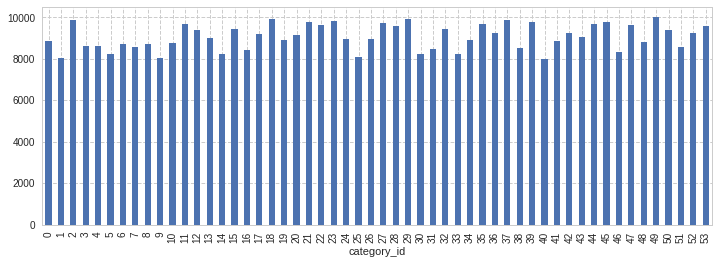

In [8]:
train.groupby("category_id").size().plot(kind="bar", figsize=(12,4));

### SVM + BOW

Fit `SVM with linear kernel` based on bag-of-words features + TF-IDF

In [0]:
# Concatenate title and description
train["text_clean"] = train["title_clean"].str.cat(train["description_clean"], sep=" ")
test["text_clean"] = test["title_clean"].str.cat(test["description_clean"], sep=" ")

In [0]:
# Initialize CV iterator
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=13)

# Pipeline
pipe = Pipeline([("bow", TfidfVectorizer(analyzer="word")),
                 ("model", LinearSVC(dual=False, class_weight="balanced"))
                ])

# Parameters to tune
params = {"model__C": [0.02],
          "model__penalty": ["l2"],
          "bow__binary": [False],
          "bow__stop_words": [None],
          "bow__lowercase": [False],
          "bow__max_features": [20_000],
          "bow__ngram_range": [(1,1)],
          "bow__use_idf": [False],
          "bow__smooth_idf": [False],
          "bow__norm": [None],
          "bow__sublinear_tf": [False],
         }

# Grid Search
gs = GridSearchCV(estimator=pipe,
                  param_grid=params,
                  scoring="accuracy",
                  cv=cv,
                  verbose=1,
                  n_jobs=-1,
                  return_train_score=True,
                  refit=False,
                 );

gs.fit(train[["text_clean"]], train["category_id"]);

# Accuracy
acc_train = gs.cv_results_["mean_train_score"][gs.best_index_]
acc_test = gs.cv_results_["mean_test_score"][gs.best_index_]

print(f"mean in-sample accuracy: {acc_train:.4f}")
print(f"mean out-of-sample accuracy: {acc_test:.4f}")
print("best params: {}".format(gs.best_params_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 16.2min remaining: 24.3min


mean train accuracy: 0.91
mean test accuracy: 0.88
best params: {'features__bow__vectorizer__binary': False, 'features__bow__vectorizer__lowercase': False, 'features__bow__vectorizer__max_features': 20000, 'features__bow__vectorizer__ngram_range': (1, 1), 'features__bow__vectorizer__norm': None, 'features__bow__vectorizer__smooth_idf': False, 'features__bow__vectorizer__stop_words': None, 'features__bow__vectorizer__sublinear_tf': False, 'features__bow__vectorizer__use_idf': False, 'model__C': 0.02, 'model__penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.3min finished


→ Not bad. Let's try to improve result using more sophisticated algorithm

### CNN

Split part of train data into validation set

In [0]:
# Leave 15% of data for validation set
X_train, X_val, y_train, y_val = \
            train_test_split(train, train["category_id"],
                             stratify=train["category_id"], 
                             random_state=13,
                             test_size=0.15
                            )

X_test = test

Prepare data

In [0]:
# Vocabulary size
max_words = 100_000

# Description
tok_desc = Tokenizer(num_words=max_words)
tok_desc.fit_on_texts(X_train["description_clean"])
desc_train = tok_desc.texts_to_sequences(X_train["description_clean"])
desc_val = tok_desc.texts_to_sequences(X_val["description_clean"])
desc_test = tok_desc.texts_to_sequences(X_test["description_clean"])

# Title
tok_title = Tokenizer(num_words=max_words)
tok_title.fit_on_texts(X_train["title_clean"])
title_train = tok_title.texts_to_sequences(X_train["title_clean"])
title_val = tok_title.texts_to_sequences(X_val["title_clean"])
title_test = tok_title.texts_to_sequences(X_test["title_clean"])

# Other features
cols_other = ["price"]
scaler = StandardScaler();
other_train = scaler.fit_transform(X_train[cols_other])
other_val = scaler.transform(X_val[cols_other])
other_test = scaler.transform(X_test[cols_other])

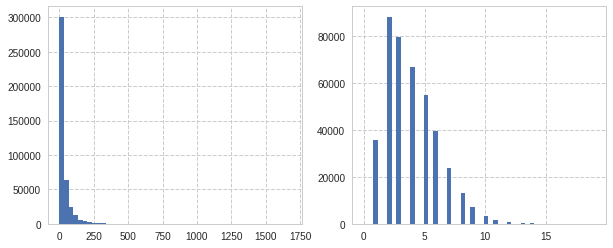

In [7]:
# Plot distributions of text lengths
fig, ax = plt.subplots(1, 2, figsize=(10,4));
ax[0].hist([len(x) for x in desc_train], bins=50);
ax[1].hist([len(x) for x in title_train], bins=50);

→ Most texts have < 250 words

In [0]:
desc_len = 250
title_len = 15

# Sequences of indices to matrix
desc_train = pad_sequences(desc_train, truncating="post", maxlen=desc_len)
desc_val = pad_sequences(desc_val, truncating="post", maxlen=desc_len)
desc_test = pad_sequences(desc_test, truncating="post", maxlen=desc_len)

title_train = pad_sequences(title_train, truncating="post", maxlen=title_len)
title_val = pad_sequences(title_val, truncating="post", maxlen=title_len)
title_test = pad_sequences(title_test, truncating="post", maxlen=title_len)

# Target vector with labels to matrix
num_classes = y_train.unique().shape[0]
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

CNN architecture

In [9]:
# Build Keras CNN model
def CNN():
    # Description input
    desc_input = Input(shape=(desc_len,), dtype='int32', name='desc_input')
    desc_x = Embedding(max_words, 300, input_length=desc_len)(desc_input)
    desc_x = SpatialDropout1D(0.5)(desc_x)
    desc_x = Convolution1D(256, 3, activation="relu")(desc_x)
    desc_x = GlobalMaxPool1D()(desc_x)
    
    # Title input
    title_input = Input(shape=(title_len,), dtype='int32', name='title_input')
    title_x = Embedding(max_words, 300, input_length=title_len)(title_input)
    title_x = SpatialDropout1D(0.5)(title_x)
    title_x = Convolution1D(256, 3, activation="relu")(title_x)
    title_x = GlobalMaxPool1D()(title_x)
    
    # Other input
    other_input = Input(shape=(len(cols_other),), name='other_input')
    x = concatenate([desc_x, title_x, other_input])
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation='linear', name="output")(x)
    model = Model(inputs=[desc_input, title_input, other_input], outputs=[out])
    return model

model = CNN()

# Compile model
model.summary()
model.compile(loss='categorical_hinge', optimizer='adam', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
desc_input (InputLayer)         (None, 250)          0                                            
__________________________________________________________________________________________________
title_input (InputLayer)        (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 250, 300)     30000000    desc_input[0][0]                 
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 15, 300)      30000000    title_input[0][0]                
__________________________________________________________________________________________________
spatial_dr

Train CNN

In [10]:
# Fit the model with early stopping
model.fit(x=[desc_train, title_train, other_train],
          y=y_train,
          validation_data=([desc_val, title_val, other_val], y_val),
          batch_size=2048,
          epochs=20,
          callbacks=[EarlyStopping(monitor='val_loss',
                                   min_delta=0.0001, 
                                   restore_best_weights=True)]
         )

Train on 416089 samples, validate on 73428 samples
Epoch 1/20
416089/416089 [==============================] - 149s 358us/step - loss: 0.6041 - acc: 0.6869 - val_loss: 0.3146 - val_acc: 0.8632
Epoch 2/20
416089/416089 [==============================] - 144s 345us/step - loss: 0.2899 - acc: 0.8786 - val_loss: 0.2695 - val_acc: 0.8843
Epoch 3/20
416089/416089 [==============================] - 144s 345us/step - loss: 0.2399 - acc: 0.9022 - val_loss: 0.2597 - val_acc: 0.8888
Epoch 4/20
416089/416089 [==============================] - 143s 345us/step - loss: 0.2091 - acc: 0.9159 - val_loss: 0.2594 - val_acc: 0.8912
Epoch 5/20
416089/416089 [==============================] - 144s 347us/step - loss: 0.1862 - acc: 0.9262 - val_loss: 0.2625 - val_acc: 0.8908


→ Now we have slightly better results than with SVM

In [0]:
# Save model
model.save(dir_path + "cnn_keras.h5")
# model = load_model(dir_path + "cnn_keras.h5")

Make predictions for validation data and calculate accuracy for various hierarchical levels

In [0]:
# Make predictions
X_val["prediction_id"] = model.predict(x=[desc_val, title_val, other_val]).argmax(axis=-1)

# Provide category labels
X_val = pd.merge(X_val, category, left_on="category_id", right_index=True)
X_val = pd.merge(X_val, category, left_on="prediction_id", right_index=True, suffixes=("_true", "_pred"))

In [23]:
# Calculate accuracy for each level of validation set
for lvl in ("name", "level_0", "level_1", "level_2"):    
    acc_lvl = (X_val[lvl + "_true"] == X_val[lvl + "_pred"]).sum() / X_val.shape[0]
    print(f"{lvl}: {acc_lvl:.4f}")

name: 0.8912
level_0: 0.9640
level_1: 0.9461
level_2: 0.8972


Create submission file for test data

In [0]:
# Predict
X_test["category_id"] = model.predict(x=[desc_test, title_test, other_test]).argmax(axis=-1)
subm = X_train[["category_id"]]

# Save to csv
subm.to_csv(dir_path + "submission.csv", index=True)